In [2]:
# -------------------------------------------------------------------------------------------------------------------
# Course name - Exploratory data analysis
# Course code - DSC530
# Week 8 assignment
# Script name - Shekhar530Week8.ipynb
# Creator - Manish Shekhar
# Date created - Jan 30th - Feb 3rd 2023
# -------------------------------------------------------------------------------------------------------------------

#### Example 9-1 :  As sample size increases, the power of a hypothesis test increases, which means it is more likely to be positive if the effect is
#### real. Conversely, as sample size decreases, the test is less likely to be positive even if the effect is real.To investigate this behavior, 
#### run the tests in this chapter with different subsets of the NSFG data. You can use thinkstats2.SampleRows to select a random subset of the rows 
#### in a DataFrame. What happens to the p-values of these tests as the sample size decreases? What is the smallest sample size that yields a positive test?

In [53]:
import numpy as np
import random
import thinkstats2
import thinkplot
import matplotlib
import pandas
import matplotlib.pyplot as plt

In [6]:
# To compute the p-value of an observed difference in means, we can assume that there is no difference between the groups 
# and generate simulated results by shuffling the data.

class DiffMeansPermute(thinkstats2.HypothesisTest):

    def TestStatistic(self, data):
        group1, group2 = data
        test_stat = abs(group1.mean() - group2.mean())
        return test_stat

    def MakeModel(self):
        group1, group2 = self.data
        self.n, self.m = len(group1), len(group2)
        self.pool = np.hstack((group1, group2))

    def RunModel(self):
        np.random.shuffle(self.pool)
        data = self.pool[:self.n], self.pool[self.n:]
        return data

In [13]:
# To check whether an observed correlation is statistically significant, we can run a permutation test with a different test statistic.

class CorrelationPermute(thinkstats2.HypothesisTest):

    def TestStatistic(self, data):
        xs, ys = data
        test_stat = abs(thinkstats2.Corr(xs, ys))
        return test_stat

    def RunModel(self):
        xs, ys = self.data
        xs = np.random.permutation(xs)
        return xs, ys

In [14]:
# Chi-squared test for pregnancy length

class PregLengthTest(thinkstats2.HypothesisTest):

    def MakeModel(self):
        firsts, others = self.data
        self.n = len(firsts)
        self.pool = np.hstack((firsts, others))

        pmf = thinkstats2.Pmf(self.pool)
        self.values = range(35, 44)
        self.expected_probs = np.array(pmf.Probs(self.values))

    def RunModel(self):
        np.random.shuffle(self.pool)
        data = self.pool[:self.n], self.pool[self.n:]
        return data
    
    def TestStatistic(self, data):
        firsts, others = data
        stat = self.ChiSquared(firsts) + self.ChiSquared(others)
        return stat

    def ChiSquared(self, lengths):
        hist = thinkstats2.Hist(lengths)
        observed = np.array(hist.Freqs(self.values))
        expected = self.expected_probs * len(lengths)
        stat = sum((observed - expected)**2 / expected)
        return stat

In [18]:
# Running three different tests
# test1: difference in mean pregnancy length
# test2: difference in mean birth weight
# test3: correlation of mother's age and birth weight
# test4: chi-square test of pregnancy length

def RunTests(live, iters=1000):
    """Runs the tests from Chapter 9 with a subset of the data.

    live: DataFrame
    iters: how many iterations to run
    """
    n = len(live)
    firsts = live[live.birthord == 1]
    others = live[live.birthord != 1]

    # compare pregnancy lengths
    data = firsts.prglngth.values, others.prglngth.values
    ht = DiffMeansPermute(data)
    p1 = ht.PValue(iters=iters)

    data = (firsts.totalwgt_lb.dropna().values,
            others.totalwgt_lb.dropna().values)
    ht = DiffMeansPermute(data)
    p2 = ht.PValue(iters=iters)

    # test correlation
    live2 = live.dropna(subset=['agepreg', 'totalwgt_lb'])
    data = live2.agepreg.values, live2.totalwgt_lb.values
    ht = CorrelationPermute(data)
    p3 = ht.PValue(iters=iters)

    # compare pregnancy lengths (chi-squared)
    data = firsts.prglngth.values, others.prglngth.values
    ht = PregLengthTest(data)
    p4 = ht.PValue(iters=iters)

    print('%d\t%0.2f\t%0.2f\t%0.2f\t%0.2f' % (n, p1, p2, p3, p4))

In [1]:
# Reading the pregnancy data file and creating live, first, and others data frames
# Capturing pregnancy lengths of first and others

import first

live, firsts, others = first.MakeFrames()
data = firsts.prglngth.values, others.prglngth.values

In [2]:
live.head()

,caseid,pregordr,howpreg_n,howpreg_p,moscurrp,nowprgdk,pregend1,pregend2,nbrnaliv,multbrth,...,laborfor_i,religion_i,metro_i,basewgt,adj_mod_basewgt,finalwgt,secu_p,sest,cmintvw,totalwgt_lb
0,1,1,NaN,NaN,NaN,NaN,6.0,NaN,1.0,NaN,...,0,0,0,3410.389399,3869.349602,6448.271112,2,9,NaN,8.8125
1,1,2,NaN,NaN,NaN,NaN,6.0,NaN,1.0,NaN,...,0,0,0,3410.389399,3869.349602,6448.271112,2,9,NaN,7.8750
2,2,1,NaN,NaN,NaN,NaN,5.0,NaN,3.0,5.0,...,0,0,0,7226.301740,8567.549110,12999.542264,2,12,NaN,9.1250
3,2,2,NaN,NaN,NaN,NaN,6.0,NaN,1.0,NaN,...,0,0,0,7226.301740,8567.549110,12999.542264,2,12,NaN,7.0000
4,2,3,NaN,NaN,NaN,NaN,6.0,NaN,1.0,NaN,...,0,0,0,7226.301740,8567.549110,12999.542264,2,12,NaN,6.1875


In [17]:
n = len(live)
for _ in range(7):
    sample = thinkstats2.SampleRows(live, n)
    RunTests(sample)
    n //= 2

9148	0.17	0.00	0.00	0.00
4574	0.29	0.02	0.00	0.00
2287	0.53	0.02	0.00	0.00
1143	0.72	0.07	0.08	0.16
571	0.60	0.55	0.03	0.01
285	0.62	0.48	0.54	0.64
142	0.90	0.47	0.61	0.62


In [19]:
# n       test1   test2   test2   test4
# 9148	0.17	0.00	0.00	0.00
# 4574	0.29	0.02	0.00	0.00
# 2287	0.53	0.02	0.00	0.00
# 1143	0.72	0.07	0.08	0.16
# 571	0.60	0.55	0.03	0.01
# 285	0.62	0.48	0.54	0.64
# 142	0.90	0.47	0.61	0.62

In [20]:
# Conclusion: As expected, tests that are positive with large sample
# sizes become negative as we take away data.  But the pattern is
# erratic, with some positive tests even at small sample sizes.

#### Example 10-1 : Using the data from the BRFSS, compute the linear least squares fit for log(weight) versus height. How would you best present the
#### estimated parameters for a model like this where one of the variables is log-transformed? If you were trying to guess someone’s weight, how much
#### would it help to know their height?Like the NSFG, the BRFSS oversamples some groups and provides a sampling weight for each respondent. 
#### In the BRFSS data, the variable name for these weights is totalwt. Use resampling, with and without weights, to estimate the mean height of
#### respondents in the BRFSS, the standard error of the mean, and a 90% confidence interval. How much does correct weighting affect the estimates?

In [9]:
# Utilizing user defined functions in brfss.py to read and clean the brfss dataset
import brfss

df = brfss.ReadBrfss(nrows=None)

df.head()

,age,sex,wtyrago,finalwt,wtkg2,htm3
0,82.0,2,76.363636,185.870345,70.91,157.0
1,65.0,2,72.727273,126.603027,72.73,163.0
2,48.0,2,NaN,181.063210,NaN,165.0
3,61.0,1,73.636364,517.926275,73.64,170.0
4,26.0,1,88.636364,1252.624630,88.64,185.0


In [10]:
# drop NAs from the height and weight columns 
df = df.dropna(subset=['htm3', 'wtkg2'])

In [11]:
# Read height and weight into separate data frames and calculate log of weights
heights, weights = df.htm3, df.wtkg2
log_weights = np.log10(weights)

In [13]:
# Estimate intercept and slope utilizing Thinkstats LeastSquares() user defined function
# Function takes two variables xs and ys and estimates the linear relationship 
# xs here is height and ys is log_weights
inter, slope =  thinkstats2.LeastSquares(heights, log_weights)
print(inter, slope)

0.9930804163917974 0.005281454169417895


In [77]:
# Utilizing thinkstats FitLine() to predict yhat from xs, calculated intercept and slope
fit_height, fit_log_weight = thinkstats2.FitLine(heights, inter, slope)


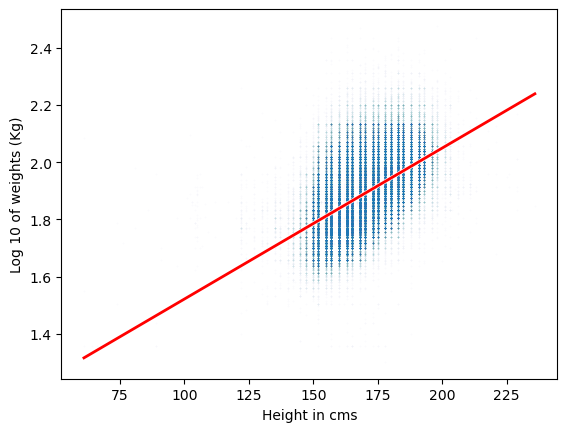

In [101]:
# To present the model parameters will use the scatter plot to show difference between plot with log transformed vaariable 
# and another with non log transformed variable
# Scatterplot of heights vs log weights

# Add jittering for heights
# heights_jitter = heights + np.random.normal(0, 2, size=395832)
# log_weights_jitter = log_weights + np.random.normal(0, 2, size=395832)
# Scatter Plot the with fitted line showing prediction 
# plt.plot(heights_jitter, log_weights_jitter, 'o', markersize=0.6, alpha=0.01)
# plt.axis([140, 200, -6, 8])
plt.plot(heights, log_weights, 'o', markersize=0.6, alpha=0.01)

# plot the line of prediction
plt.plot(fit_height, fit_log_weight, color='white', linewidth=3)
plt.plot(fit_height, fit_log_weight, color='red', linewidth=2)

# Label the axes
plt.xlabel('Height in cms')
plt.ylabel('Log 10 of weights (Kg)')
plt.show()

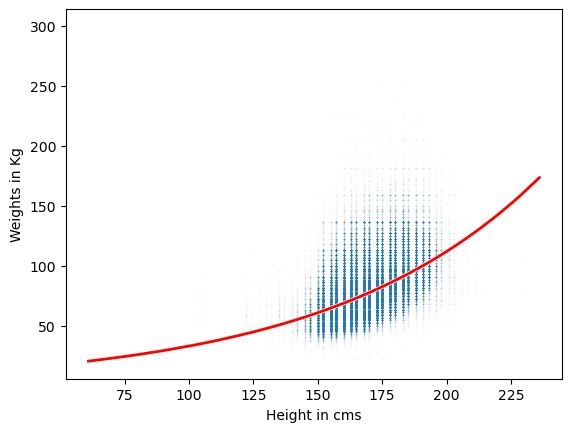

In [106]:
# Make the same plot but apply the inverse transform to show weights on a linear (not log) scale.
plt.plot(heights, weights, 'o', markersize=0.6, alpha=0.01)
fit_height, fit_weight = thinkstats2.FitLine(heights, inter, slope)
plt.plot(fit_height, 10**fit_weight, color='white', linewidth=3)
plt.plot(fit_height, 10**fit_weight, color='red', linewidth=2)

# Label the axes
plt.xlabel('Height in cms')
plt.ylabel('Weights in Kg')
plt.show()

In [167]:
################################ Observations ######################################
# It is clear that there exists linear relationship between heights and log of weights
# Given height the model will clearly help to tell the predicted log 10 of weight
# of the person. We can then use 10**Predicted Weight to get the predicted weight in Kg.
#
# Relationship between heights and weight though is not perfectly linear as we can see
# fitted line line curves.
#
# We can see that weight steadily increases as height of the person increases till 
# about 150 cms and later weight increases exponentially until 225 cms height
# Given intercept, slope, and height we can easily predict coreesponding weight.
####################################################################################

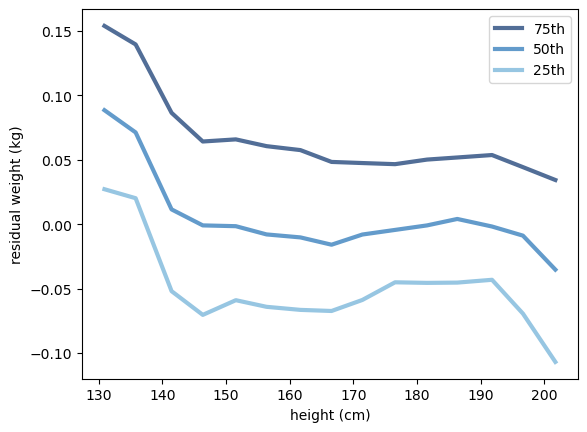

In [108]:
# To further check linearity of the relationship we can calculate residuals and plot it against 
# independent variable i.e. height.

# Plot percentiles of the residuals
res = thinkstats2.Residuals(heights, log_weights, inter, slope)
df['residual'] = res

bins = np.arange(130, 210, 5)
indices = np.digitize(df.htm3, bins)
groups = df.groupby(indices)

means = [group.htm3.mean() for i, group in groups][1:-1]
cdfs = [thinkstats2.Cdf(group.residual) for i, group in groups][1:-1]

thinkplot.PrePlot(3)
for percent in [75, 50, 25]:
    ys = [cdf.Percentile(percent) for cdf in cdfs]
    label = '%dth' % percent
    thinkplot.Plot(means, ys, label=label)
    
thinkplot.Config(xlabel='height (cm)', ylabel='residual weight (kg)', legend=True)

In [148]:
############################## Observations ########################################
# 50th percentile line is about half a time at 0 residual (which is good) while 
# at other times it is fluctuating between 0.1 and -0.05.
# This behaviour indicates that the relationship is not linear all the time.

# The lines are mostly parallel, indicating 
# that the variance of the residuals is the 
# same over the range.
#####################################################################################

In [149]:
# compute correlation
rho = thinkstats2.Corr(heights, log_weights)
rho

0.5317282605983519

In [150]:
# compute coefficient of determination
r2 = thinkstats2.CoefDetermination(log_weights, res)
r2

0.28273494311893377

In [114]:
# Confirm that  𝑅2=𝜌2

In [151]:
np.isclose(rho**2, r2)

True

In [117]:
# Compute Std(ys), which is the RMSE of predictions that don't use height.

In [152]:
std_ys = thinkstats2.Std(log_weights)
std_ys

0.10320725030004854

In [119]:
# Compute Std(res), the RMSE of predictions that do use height.

In [153]:
std_res = thinkstats2.Std(res)
std_res

0.08740777080416093

In [121]:
# How much does height information reduce RMSE?

In [155]:
1 - std_res / std_ys

0.15308497658793052

In [123]:
# Use resampling to compute sampling distributions for inter and slope.

In [157]:
t = []
for _ in range(100):
    sample = thinkstats2.ResampleRows(df)
    estimates = thinkstats2.LeastSquares(sample.htm3, np.log10(sample.wtkg2))
    t.append(estimates)

inters, slopes = zip(*t)

In [125]:
# Plot the sampling distribution of slope.

{'xscale': 'linear', 'yscale': 'linear'}

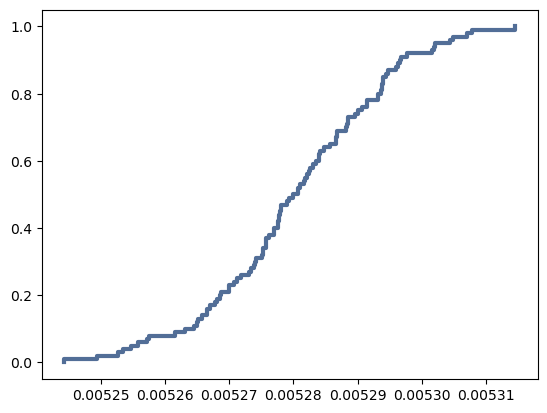

In [158]:
cdf = thinkstats2.Cdf(slopes)
thinkplot.Cdf(cdf)

In [127]:
# Compute the p-value of the slope.

In [159]:
pvalue = cdf[0]
pvalue

0

In [129]:
# Compute the 90% confidence interval of slope

In [160]:
ci = cdf.Percentile(5), cdf.Percentile(95)
ci

(0.005254773651148464, 0.0053020927729020804)

In [131]:
# Compute the mean of the sampling distribution.

In [161]:
mean = thinkstats2.Mean(slopes)
mean

0.005280396185885794

In [133]:
# Compute the standard deviation of the sampling distribution, which is the standard error.

In [162]:
stderr = thinkstats2.Std(slopes)
stderr

1.3756286671652704e-05

In [163]:
# Resample rows without weights, compute mean height, and summarize results.
# The following function takes a list of estimates and prints the mean, standard error, and 90% confidence interval.
from thinkstats2 import Mean, MeanVar, Var, Std, Cov

def Summarize(estimates, actual=None):
    mean = Mean(estimates)
    stderr = Std(estimates, mu=actual)
    cdf = thinkstats2.Cdf(estimates)
    ci = cdf.ConfidenceInterval(90)
    print('mean, SE, CI', mean, stderr, ci)

In [164]:
estimates_unweighted = [thinkstats2.ResampleRows(df).htm3.mean() for _ in range(100)]
Summarize(estimates_unweighted)

mean, SE, CI 168.95665009397922 0.015500584811720805 (168.93025829139634, 168.98339952302996)


In [141]:
# Resample rows with weights. Note that the weight column in this dataset is called finalwt

In [178]:
## Resampling with weights

# Resampling provides a convenient way to take into account the sampling weights associated with respondents in a stratified survey design.
# The following function resamples rows with probabilities proportional to weights.
def ResampleRowsWeighted(df, column='finalwt'):
    weights = df[column]
    cdf = thinkstats2.Cdf(dict(weights))
    indices = cdf.Sample(len(weights))
    sample = df.loc[indices]
    return sample

In [179]:
estimates_weighted = [ResampleRowsWeighted(df, 'finalwt').htm3.mean() for _ in range(100)]
Summarize(estimates_weighted)

mean, SE, CI 170.49648456921122 0.017243846478423603 (170.47059611148163, 170.5270847228117)


In [ ]:
################################# Observations ######################################
# The estimated mean height is almost 2 cm taller 
# if we take into account the sampling weights,
# and this difference is much bigger than the sampling error.
#####################################################################################